# ProtVI

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import torch

from scp.models import PROTVI
import scp.plots as pl
import scp.utils as utils
import scp.metrics as metrics
import scp.simulations as sm
from scp.benchmark_models import run_protDP

import scvi

np.random.seed(0)
torch.manual_seed(0)
scvi.settings.seed = 0

Global seed set to 0


Let"s load the data.

In [2]:
adata = sc.read_h5ad("../../data/processed/schoof_protein_pca.h5ad")

adata.layers["raw_sn"] = adata.layers["log2_raw_sn"].copy()
adata.layers["raw_sn"][np.isnan(adata.layers["median_ratios"])] = np.nan

adata.X = adata.layers["raw_sn"].copy()

In [3]:
adata

AnnData object with n_obs × n_vars = 2541 × 1034
    obs: 'File ID', 'Channel', 'File Name', 'Plate', 'Sample', 'Row', 'Column', 'Well', 'Sorted Population', 'FSC-A', 'FSC-W', 'FSC-H', 'SSC-A', 'SSC-W', 'SSC-H', 'CD38 FACS', 'EMCN FACS', 'CD34 FACS', 'Lineage Cocktail FACS', 'CD123 FACS', 'CD90 FACS', 'CD49f FACS', 'CD45RA FACS', 'CD10 FACS', 'Time', 'Gated Population', 'Gate Path', 'QC leiden', 'Pass Cluster Filter', 'Individual', 'Num Proteins', 'Log2 Sum S/N', 'Pass Cell Filter', 'log2_sum_filter', 'leiden', 'Cluster Label', 'domain', 'cell_type', 'cell_type_confidence', 'phase', 'phase_confidence'
    var: 'Accession', 'Description', 'Biological Process', 'Cellular Component', 'Molecular Function', 'KEGG Pathways', 'Reactome Pathways', 'WikiPathways', 'n_cells', 'Matching Accession', 'Matched ENSG', 'Gene Symbol Protein', 'Gene Symbol RNA', 'Gene Symbol Combined', 'max_fold_change', 'Cluster'
    uns: 'Channel_colors', 'Cluster Label_colors', 'Column_colors', 'Gated Population_colo

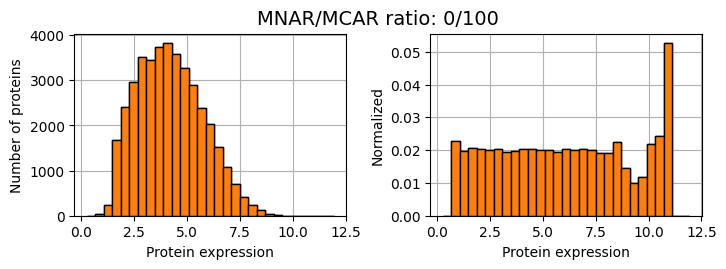

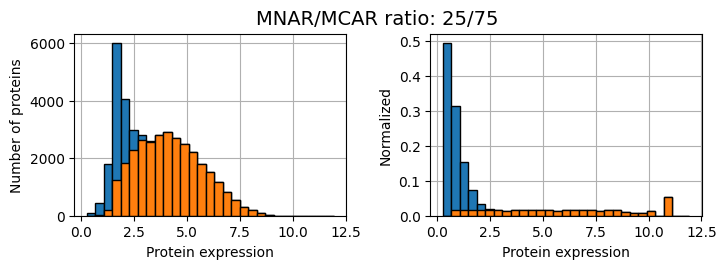

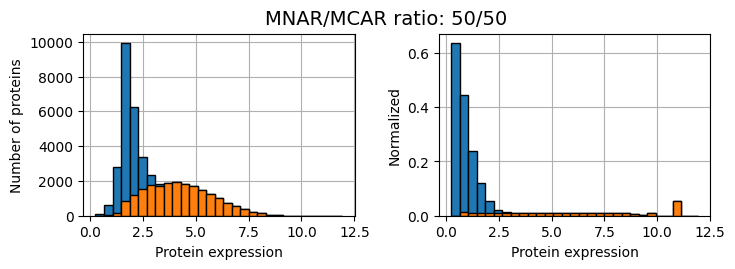

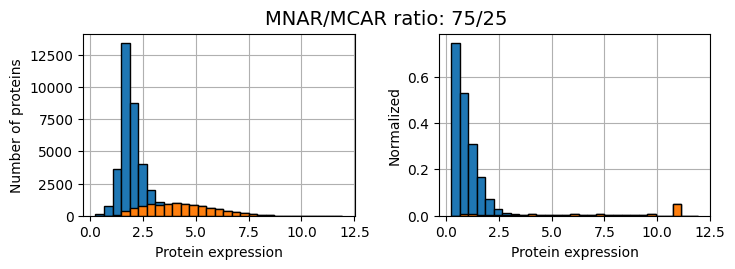

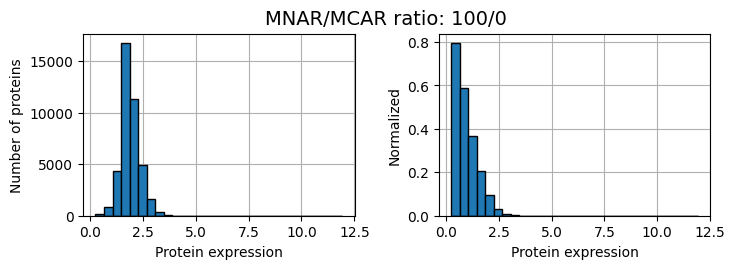

In [4]:
mnar_proportions = [0, 0.25, 0.5, 0.75, 1]

for mnar_proportion in mnar_proportions:
    m_mnar, m_mcar = sm.create_mnar_mcar_mask(mv_rate=0.02, mnar_proportion=mnar_proportion, x=adata.layers["raw_sn"], seed=42)

    fig, axes = plt.subplots(1, 2, figsize=(7, 2.5))
    fig.suptitle(f"MNAR/MCAR ratio: {100*mnar_proportion:.0f}/{100*(1-mnar_proportion):.0f}", fontsize=14)
    fig.tight_layout(w_pad=3)
    fig.subplots_adjust(top=0.88)

    pl.plot_mnar_mcar_ratio(adata, m_mnar, m_mcar, ax=axes[0])
    pl.plot_mnar_mcar_ratio(adata, m_mnar, m_mcar, ax=axes[1], normalize=True)

    fig.savefig(f"mnar_mcar_ratio_{mnar_proportion:.2f}.svg")

In [5]:
adata = sc.read_h5ad("../../data/processed/schoof_protein_pca.h5ad")

adata.layers["raw_sn"] = adata.layers["log2_raw_sn"].copy()
adata.layers["raw_sn"][np.isnan(adata.layers["median_ratios"])] = np.nan

adata.X = adata.layers["raw_sn"].copy()

In [6]:
adata.layers["raw_sn"] = adata.layers["log2_raw_sn"].copy()
adata.layers["raw_sn"][np.isnan(adata.layers["median_ratios"])] = np.nan

##  Mask-and-impute experiments

In [7]:
# mnar_proportion: 0, 0.25, 0.5, 0.75, 1 
mnar_proportion = 0

m_mnar, m_mcar = sm.create_mnar_mcar_mask(mv_rate=0.02, mnar_proportion=mnar_proportion, x=adata.layers["raw_sn"], seed=42)

In [8]:
print(f"MNAR: {np.sum(m_mnar) / m_mnar.size:.3f}, MCAR: {np.sum(m_mcar) / m_mcar.size:.3f}")

MNAR: 0.000, MCAR: 0.020


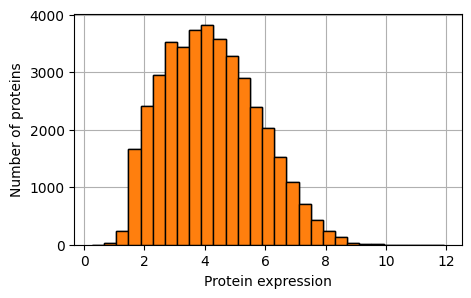

In [9]:
pl.plot_mnar_mcar_ratio(adata, m_mnar, m_mcar)

In [10]:
train_mask = ~(m_mcar | m_mnar)

sm.add_train_test_set(adata, train_mask, layer="raw_sn")

## PROTVI

### Training

Let's now train the model.

In [11]:
adata.X = adata.layers["train"].copy()
adata.X[np.isnan(adata.X)] = 0

In [12]:
PROTVI.setup_anndata(adata, 
                     batch_key="Plate",
                     #categorical_covariate_keys = ['Channel', 'File ID'],
                     #continuous_covariate_keys=["Num Proteins","Log2 Sum S/N"], 
                    )

model = PROTVI(adata, log_variational=False, n_hidden=64, n_layers=2, decoder_type="selection", dropout_rate=0.3)
#model.view_anndata_setup()

Let's train the model.

In [13]:
model.train(max_epochs=3000, plan_kwargs={"mechanism_weight": 0, "kl_weight":.1}, check_val_every_n_epoch=1)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 488/3000:  16%|█▌        | 487/3000 [03:48<29:36,  1.41it/s, v_num=1, train_loss_step=794, train_loss_epoch=793]      

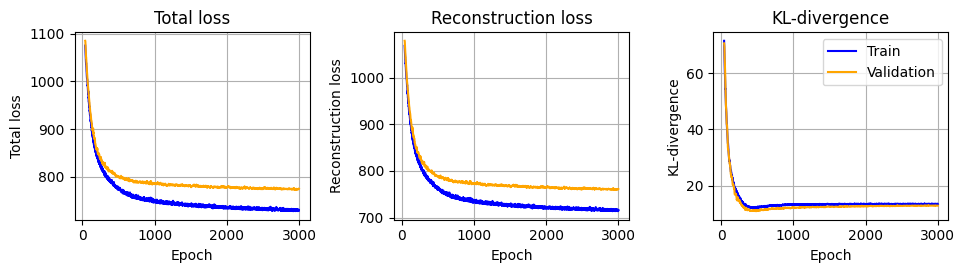

In [ ]:
pl.plot_loss(model.history, epoch_start=40, validation_smooth_window=10)

In [ ]:
model.save(f"mai_protvi_baseline_{mnar_proportion}")

### Evaluation on training set (MAIN)

In [ ]:
x_est, p_est, x_var = model.impute(n_samples=100)

In [ ]:
x_test = adata.layers["test"]

x_guess = x_est[~np.isnan(x_test)]
x_true = x_test[~np.isnan(x_test)]

mse_test = metrics.mse(x_guess, x_true)

print(f"Test MSE (individual): {mse_test:.4f}")

Test MSE (individual): 0.4213


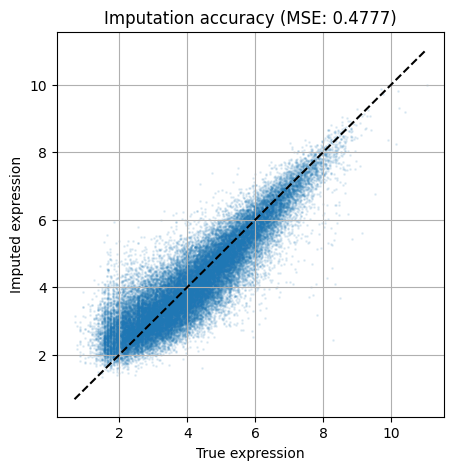

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

v_min = np.min([np.nanmin(x_true), np.nanmin(x_guess)])
v_max = np.max([np.nanmax(x_true), np.nanmax(x_guess)])

ax.plot([v_min, v_max], [v_min, v_max], ls="--", c="black")
ax.scatter(x_true, x_guess, s=1, alpha=0.1)
ax.set_xlabel("True expression")
ax.set_ylabel("Imputed expression")
ax.set_title(f"Imputation accuracy (MSE: {mse_test:.4f})")
ax.grid(True)

In [ ]:
x_guess_means = np.nanmean(x_guess, axis=0)
x_true_means = np.nanmean(x_true, axis=0)

mse_test_agg = np.nanmean(x_guess_means - x_true_means)**2

print(f"Test MSE (aggregate): {mse_test_agg:.4f}")

Test MSE (aggregate): 0.0044
